In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import requests
import os
from PIL import Image
import joblib



%matplotlib inline

In [ ]:
url_clickbait = 'https://raw.githubusercontent.com/Filip1402/YoutubeClickbaitDetector/main/dataset2/clickbait.csv'
url_not_clickbait = 'https://raw.githubusercontent.com/Filip1402/YoutubeClickbaitDetector/main/dataset2/notClickbait.csv'

my_df_clickbait = pd.read_csv(url_clickbait)
#my_df_clickbait.insert(6,'Clickbait',value=1,allow_duplicates=True)
my_df_not_clickbait = pd.read_csv(url_not_clickbait)
#my_df_not_clickbait.insert(6,'Clickbait',value=0,allow_duplicates=True)
my_df  = pd.concat([my_df_clickbait, my_df_not_clickbait], ignore_index=True)

In [ ]:
my_df = my_df.drop("ID",axis=1)
my_df = my_df.drop("Video Title",axis=1)
my_df = my_df.drop("Description",axis=1)
my_df = my_df.dropna()
my_df_dislike_like_ratio = my_df.assign(Like_Dislike_Ratio=my_df['Dislikes'] / my_df['Likes'])["Like_Dislike_Ratio"]
my_df_views_like_ratio = my_df.assign(View_Like_Ratio=my_df['Likes'] / my_df['Views'])["View_Like_Ratio"]
my_df_views_dislike_ratio = my_df.assign(View_Dislike_Ratio=my_df['Dislikes'] / my_df['Views'])["View_Dislike_Ratio"]
my_df_views_comment_ratio = my_df.assign(View_Comment_Ratio=my_df['Comment Count'] / my_df['Views'])["View_Comment_Ratio"]

my_df = pd.concat([my_df, my_df_dislike_like_ratio], axis = 1)
my_df = pd.concat([my_df, my_df_views_like_ratio], axis = 1)
my_df = pd.concat([my_df, my_df_views_dislike_ratio], axis = 1)
my_df = pd.concat([my_df, my_df_views_comment_ratio], axis = 1)

my_df['Like_Dislike_Ratio'].fillna(0.0, inplace=True)
my_df['View_Like_Ratio'].fillna(0.0, inplace=True)
my_df['View_Dislike_Ratio'].fillna(0.0, inplace=True)
my_df['View_Comment_Ratio'].fillna(0.0, inplace=True)

#my_df = my_df.drop("Dislikes",axis=1)
#my_df = my_df.drop("Likes",axis=1)
#my_df = my_df.drop("Comment Count",axis=1)
#my_df = my_df.drop("Views",axis=1)


In [ ]:
my_df

,Views,Likes,Dislikes,Comment Count,clickbait,Like_Dislike_Ratio,View_Like_Ratio,View_Dislike_Ratio,View_Comment_Ratio
0,40586,1966.0,9,41.0,1,0.004578,0.048440,0.000222,0.001010
1,6072,314.0,6,23.0,1,0.019108,0.051713,0.000988,0.003788
2,869597,16443.0,25964,762.0,1,1.579031,0.018909,0.029858,0.000876
3,36921,1300.0,1020,358.0,1,0.784615,0.035210,0.027627,0.009696
4,9027,364.0,6,6.0,1,0.016484,0.040323,0.000665,0.000665
...,...,...,...,...,...,...,...,...,...
1595,5069,70.0,4,10.0,0,0.057143,0.013809,0.000789,0.001973
1596,5527,156.0,2,15.0,0,0.012821,0.028225,0.000362,0.002714
1597,3109,198.0,3,53.0,0,0.015152,0.063686,0.000965,0.017047
1598,51285,1154.0,23,59.0,0,0.019931,0.022502,0.000448,0.001150


In [ ]:
scaler = MinMaxScaler()
y = my_df["clickbait"]
X = my_df.drop("clickbait", axis=1);


In [ ]:
my_df

,Views,Likes,Dislikes,Comment Count,clickbait,Like_Dislike_Ratio,View_Like_Ratio,View_Dislike_Ratio,View_Comment_Ratio
0,40586,1966.0,9,41.0,1,0.004578,0.048440,0.000222,0.001010
1,6072,314.0,6,23.0,1,0.019108,0.051713,0.000988,0.003788
2,869597,16443.0,25964,762.0,1,1.579031,0.018909,0.029858,0.000876
3,36921,1300.0,1020,358.0,1,0.784615,0.035210,0.027627,0.009696
4,9027,364.0,6,6.0,1,0.016484,0.040323,0.000665,0.000665
...,...,...,...,...,...,...,...,...,...
1595,5069,70.0,4,10.0,0,0.057143,0.013809,0.000789,0.001973
1596,5527,156.0,2,15.0,0,0.012821,0.028225,0.000362,0.002714
1597,3109,198.0,3,53.0,0,0.015152,0.063686,0.000965,0.017047
1598,51285,1154.0,23,59.0,0,0.019931,0.022502,0.000448,0.001150


In [ ]:
nan_check = my_df.isnull().values.any()

if nan_check:
    print("There are NaN values in the data.")
else:
    print("No NaN values found in the data.")

No NaN values found in the data.


In [ ]:
nan_rows = my_df[my_df.isnull().any(axis=1)]
print("Rows with NaN values:")
print(nan_rows)

# Check for NaN values in columns
nan_columns = my_df.columns[my_df.isnull().any()]
print("\nColumns with NaN values:")
print(nan_columns)

Rows with NaN values:
Empty DataFrame
Columns: [Views, Likes, Dislikes, Comment Count, clickbait, Like_Dislike_Ratio, View_Like_Ratio, View_Dislike_Ratio, View_Comment_Ratio]
Index: []

Columns with NaN values:
Index([], dtype='object')


In [ ]:
X = scaler.fit_transform(X)

In [ ]:
scaler_params = {'min_': scaler.min_, 'scale_': scaler.scale_}
joblib.dump(scaler_params, 'scaler_params.pkl')

['scaler_params.pkl']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state= 41)

In [ ]:
X_train.shape

(1256, 8)

In [ ]:
X_test.shape

(315, 8)

In [ ]:
#Convert features to float tenosrs
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test , dtype=torch.float32)
#Convert labels to long tenosrs
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test.values, dtype=torch.long)  # Convert Series values to PyTorch tensor


In [ ]:
train_data = TensorDataset(X_train,y_train)
test_data = TensorDataset(X_test,y_test)

In [ ]:
train_loader = DataLoader(train_data,batch_size=30, shuffle=True)
test_loader = DataLoader(test_data,batch_size=30, shuffle=False)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self, in_features=8, h1=64, h2=128, h3=128, h4=64, h5=32, h6=16 ,output_features=2):
        super().__init__()  # create instance of nn.Module
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, h3)
        self.fc4 = nn.Linear(h3, h4)
        self.fc5 = nn.Linear(h4, h5)
        self.fc6 = nn.Linear(h5, h6)

        self.out = nn.Linear(h6, output_features)

        # Dropout layers
       # self.dropout1 = nn.Dropout(0.05)
        #self.dropout2 = nn.Dropout(0.15)

        # Batch normalization
        #self.bn1 = nn.BatchNorm1d(h1)
        #self.bn2 = nn.BatchNorm1d(h2)
        #self.bn3 = nn.BatchNorm1d(h3)

    softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # Apply batch normalization and activation
        #x = self.dropout1(x)  # Apply dropout

        x = F.relu(self.fc2(x))  # Apply batch normalization and activation
        #x = self.dropout2(x)  # Apply dropout

        x = F.relu(self.fc3(x))
        #x = self.dropout1(x)  # Apply dropout

        x = F.relu(self.fc4(x))
        #x = self.dropout2(x)  # Apply dropout

        x = F.relu(self.fc5(x))
       # x = self.dropout1(x)  # Apply dropout
        #x = F.relu(self.bn1(self.fc1(x)))  # Apply batch normalization and activation
        #x = self.dropout1(x)  # Apply dropout

        #x = F.relu(self.bn2(self.fc2(x)))  # Apply batch normalization and activation
        #x = self.dropout2(x)  # Apply dropout

        #x = F.relu(self.bn3(self.fc3(x)))
        #x = self.dropout1(x)  # Apply dropout

        #x = F.relu(self.fc4(x))
        #x = self.dropout2(x)  # Apply dropout

        #x = F.relu(self.fc5(x))
       # x = self.dropout1(x)  # Apply dropout

        x = F.relu(self.fc6(x))
        x = self.out(x)
        return x


In [ ]:
#Pick random seed that is same as tutorial
torch.manual_seed(41)
#Create model instance
model = Model()

In [ ]:
#Loss function optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0012)
#Smaller the leraing rate longer the training time

In [ ]:
import time
start_time = time.time()

# Create Variables To Tracks Things
epochs = 480
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For Loop of Epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0

  model.train()
  # Train
  for b,(train_d, train_l) in enumerate(train_loader):
    b+=1 # start our batches at 1
    y_pred = model(train_d)
    #print(y_pred)
   # print(y_pred.shape)
    loss = criterion(y_pred, train_l) # how off are we? Compare the predictions to correct answers in y_train

    predicted = torch.max(y_pred.data, 1)[1]
    #print(predicted.squeeze())
    #print(train_l)

    batch_corr = (predicted ==  train_l).sum() # how many we got correct from this batch. True = 1, False=0, sum those up
    trn_corr += batch_corr # keep track as we go along in training.

    # Update our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if(b%20==0):
      # Print out some results
      print(f'Epoch: {i}  Batch: {b}  Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)


  # Test
  with torch.no_grad(): #No gradient so we don't update our weights and biases with test data
    #batch_test_loss = 0
    for b,(test_d, test_l) in enumerate(test_loader):
      y_val = model(test_d)
      predicted = torch.max(y_val.data, 1)[1]  # Convert logits to probabilities and round to get 0 or 1
      tst_corr += (predicted ==  test_l).sum() # T=1 F=0 and sum away
      #batch_test_loss += (loss)
  loss = criterion(y_val, test_l) # calculate loss
  test_losses.append(loss)
  #test_losses.append(batch_test_loss/epochs)
  test_correct.append(tst_corr)




current_time = time.time()
total = current_time - start_time
print(f'Training Took: {total/60} minutes!')

Epoch: 0  Batch: 20  Loss: 0.6814349889755249
Epoch: 0  Batch: 40  Loss: 0.6705390810966492
Epoch: 1  Batch: 20  Loss: 0.6744376420974731
Epoch: 1  Batch: 40  Loss: 0.7160266637802124
Epoch: 2  Batch: 20  Loss: 0.6419655680656433
Epoch: 2  Batch: 40  Loss: 0.6041398644447327
Epoch: 3  Batch: 20  Loss: 0.5539566278457642
Epoch: 3  Batch: 40  Loss: 0.5299999117851257
Epoch: 4  Batch: 20  Loss: 0.5311903953552246
Epoch: 4  Batch: 40  Loss: 0.6989110112190247
Epoch: 5  Batch: 20  Loss: 0.6162326335906982
Epoch: 5  Batch: 40  Loss: 0.7453262209892273
Epoch: 6  Batch: 20  Loss: 0.5839196443557739
Epoch: 6  Batch: 40  Loss: 0.659863293170929
Epoch: 7  Batch: 20  Loss: 0.5608794689178467
Epoch: 7  Batch: 40  Loss: 0.5393430590629578
Epoch: 8  Batch: 20  Loss: 0.5643168091773987
Epoch: 8  Batch: 40  Loss: 0.6765362024307251
Epoch: 9  Batch: 20  Loss: 0.653989851474762
Epoch: 9  Batch: 40  Loss: 0.5686047077178955
Epoch: 10  Batch: 20  Loss: 0.5916622877120972
Epoch: 10  Batch: 40  Loss: 0.53468

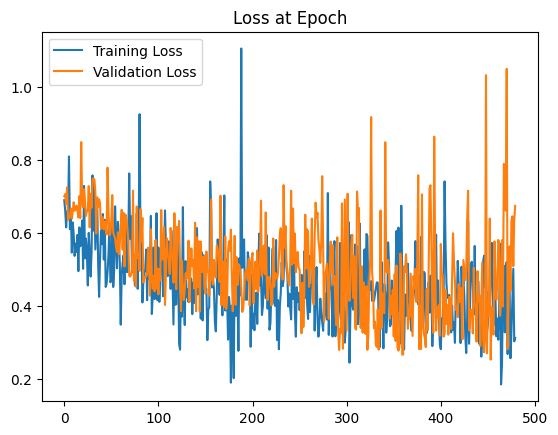

In [ ]:
train_loss = [tl.item() for tl in train_losses]
plt.plot(train_loss, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.title("Loss at Epoch")
plt.legend()

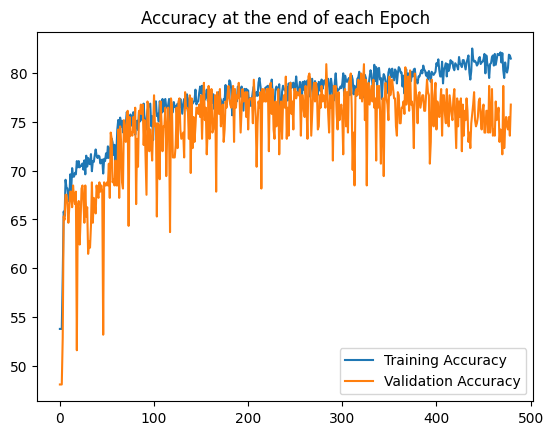

In [ ]:
plt.plot([t/12.57 for t in train_correct], label="Training Accuracy")
plt.plot([t/3.14 for t in test_correct], label="Validation Accuracy")
plt.title("Accuracy at the end of each Epoch")
plt.legend()

In [ ]:
test_load_everything = DataLoader(test_data, batch_size=len(test_data), shuffle=False)

In [ ]:
model.eval()
with torch.no_grad():
  correct = 0
  for x_validation, y_validation in test_load_everything:
    y_value = model(x_validation)
    print(y_value)
    predicted = torch.max(y_value.data, 1)[1]
    correct += (predicted == y_validation).sum()

tensor([[-7.6534e-01,  6.8425e-01],
        [-1.0320e-01, -1.3987e-01],
        [-7.0991e+00,  7.5231e+00],
        [-1.7897e-03, -2.8677e-01],
        [-8.4178e-01,  7.1230e-01],
        [-1.2087e+00,  1.0778e+00],
        [-1.7119e+00,  1.6168e+00],
        [ 9.1656e-02, -4.2833e-01],
        [ 1.0783e+00, -1.6920e+00],
        [-4.0311e+00,  4.1733e+00],
        [-8.9314e+01,  9.8482e+01],
        [-1.5712e+01,  1.7044e+01],
        [-7.0112e-01,  6.1176e-01],
        [ 5.4363e-01, -1.0416e+00],
        [-1.5324e-01, -1.0252e-01],
        [ 1.2262e+00, -1.9329e+00],
        [ 1.0768e-01, -4.2727e-01],
        [ 1.0998e-01, -4.6457e-01],
        [ 6.9323e-01, -1.2678e+00],
        [ 8.3416e-01, -1.3717e+00],
        [-4.1756e-01,  2.5220e-01],
        [-1.5064e+00,  1.4313e+00],
        [-4.7809e+00,  4.9856e+00],
        [-2.3965e-01, -3.9066e-02],
        [-3.9801e+00,  4.1028e+00],
        [-6.3934e-03, -3.2666e-01],
        [ 1.2186e-01, -4.6538e-01],
        [ 1.4951e-01, -5.465

In [ ]:
correct.item()/len(test_data)*100

76.5079365079365

In [ ]:
correct

tensor(241)

In [ ]:
torch.save(model.state_dict(), 'statisticModel.pt')

In [ ]:
newModel = Model()
newModel.load_state_dict(torch.load('statisticModel.pt'))

<All keys matched successfully>

In [ ]:
s = 0
for a, b in test_load_everything:
  c = newModel(a)
  d = torch.max(c, 1)[1]
  s += (d == b).sum()

In [ ]:
s.item()/len(test_data)*100

76.5079365079365

In [ ]:
test_data[1]

(tensor([0.0017, 0.0006, 0.0009, 0.0075, 0.0135, 0.0545, 0.0048, 0.0007]),
 tensor(0))